# Detecting Alzheimer’s disease from MRI with convolutional neural networks

Course: Intro to DL (MS CS)  
Institution: University of Colorado Boulder  
Dataset: Structural brain MRI (DICOM) with AD, MCI, and NC groups  
Date: 9 December 2025  

## Project overview

In this project, I am exploring how convolutional neural networks (CNNs) can classify brain MRI slices into diagnostic categories related to Alzheimer’s disease.

The primary goal is to understand whether deep learning models can learn meaningful visual patterns from structural brain images and distinguish between Alzheimer’s disease (AD), mild cognitive impairment (MCI), and normal controls (NC). I focus on evaluating several CNN architectures and comparing them to understand the trade off between model complexity, regularization, and performance.

The task is a multi class image classification problem, with classes corresponding to:

- AD (Alzheimer’s Disease)  
- MCI (Mild Cognitive Impairment)  
- NC (Normal Control / healthy)  

Each sample is a DICOM MRI slice labeled by the diagnostic group. I train and evaluate three main models:

- A simple baseline CNN built from scratch  
- A deeper CNN with additional convolutional blocks, batch normalization, and dropout  
- A transfer learning model that uses a pre trained convolutional base from ImageNet and a custom classification head  

The analysis follows the deep learning workflow from the course slides: formulate the problem, design CNN architectures, train them using backpropagation and gradient based optimization, monitor training and validation curves, and evaluate performance using suitable metrics.

The project also includes a small extension where I compare training the deep CNN with and without data augmentation to see how augmentation affects generalization on this medical imaging dataset.

## 1. Problem definition and data sources

### 1.1 Problem statement

The project focuses on predicting Alzheimer’s disease status from structural brain MRI slices.

The primary goal is to see how well convolutional neural networks can classify DICOM MRI slices into three diagnostic categories: AD, MCI, and NC. The assumption is that a model could, to some extent, support radiologists or automated pre screening tools by flagging scans that appear consistent with dementia, especially in settings where expert capacity is limited. The model is not a replacement for clinical diagnosis, but rather a proof of concept for how deep learning can process medical images.

The task is a multi class classification problem where the input is a 2D MRI slice and the target is a categorical label representing the diagnostic group. I evaluate models in terms of accuracy and macro F1 score on a held out test set and compare their training dynamics and generalization.

## 2. Environment setup and DICOM loading

Before starting the analysis, I will load the main libraries for data handling, visualization, and deep learning.

The goal here is to prepare the environment, set a reproducible random seed, and configure a pipeline that reads DICOM files and converts them into tensors that CNNs can process.

In [38]:
import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import pydicom
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pydicom"])
    import pydicom

# Install dependencies for decompressing DICOM files (JPEG Lossless, etc.)
try:
    import pylibjpeg
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pylibjpeg", "pylibjpeg-libjpeg"])
    import pylibjpeg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 10

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("TensorFlow version:", tf.__version__)
print("Random seed set to:", RANDOM_STATE)

TensorFlow version: 2.20.0
Random seed set to: 42


### 2.1 Collecting DICOM file paths and labels

I assume the notebook lives in the same directory as the `AD`, `MCI`, and `NC` folders. If the structure is different, the `DATA_ROOT` variable can be adjusted.

Each DICOM slice will become one sample. The label is derived from the top level folder (AD, MCI, NC).

In [39]:
# Root directory that contains the AD, MCI, and NC folders
DATA_ROOT = Path(".")

# Map folder names to numeric labels
CLASS_MAP = {"AD": 0, "MCI": 1, "NC": 2}
class_names = list(CLASS_MAP.keys())
num_classes = len(class_names)

print("Classes:", class_names)

file_paths = []
labels = []

for class_name, label_id in CLASS_MAP.items():
    class_dir = DATA_ROOT / class_name
    if not class_dir.exists():
        raise FileNotFoundError(f"Folder not found: {class_dir.resolve()}")
        
    for root, _, files in os.walk(class_dir):
        for fname in files:
            if fname.lower().endswith(".dcm"):
                file_paths.append(str(Path(root) / fname))
                labels.append(label_id)

file_paths = np.array(file_paths)
labels = np.array(labels)

print(f"Total DICOM slices found: {len(file_paths)}")

Classes: ['AD', 'MCI', 'NC']
Total DICOM slices found: 474


In [40]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    file_paths, labels,
    test_size=0.2,
    stratify=labels,
    random_state=RANDOM_STATE
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=RANDOM_STATE
)

print("Train samples:", len(train_paths))
print("Validation samples:", len(val_paths))
print("Test samples:", len(test_paths))

Train samples: 379
Validation samples: 47
Test samples: 48


## 3. EDA

The goal of this section is to understand the class balance and visualize a few example MRI slices to see what the model will be trained on.

### 3.1 Class balance

I start by counting how many slices belong to each diagnostic group in the full dataset and in the training split.

Total slices per class:
AD: 197
MCI: 204
NC: 73


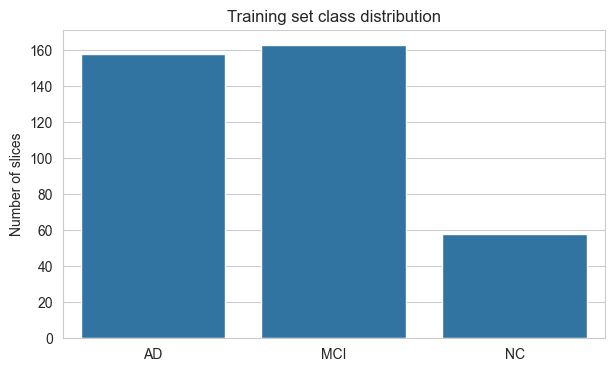

In [41]:
def count_by_label(labels, class_names):
    counts = []
    for i, name in enumerate(class_names):
        count = np.sum(labels == i)
        counts.append(count)
    return np.array(counts)

total_counts = count_by_label(labels, class_names)
train_counts = count_by_label(train_labels, class_names)

print("Total slices per class:")
for name, count in zip(class_names, total_counts):
    print(f"{name}: {count}")

plt.figure(figsize=(7, 4))
sns.barplot(x=class_names, y=train_counts)
plt.title("Training set class distribution")
plt.ylabel("Number of slices")
plt.show()

The class distribution shows a noticeable imbalance: NC slices are significantly fewer than AD and MCI. This is common in clinical datasets where healthy controls are underrepresented. This imbalance will need to be considered later when interpreting accuracy and macro F1 scores, since models may overpredict the majority classes (AD and MCI). It also motivates the later use of data augmentation to improve generalization.

### 3.2 Visualizing example MRI slices

Next, I load and show a few example slices from each class to get an intuition for the visual appearance of the data.

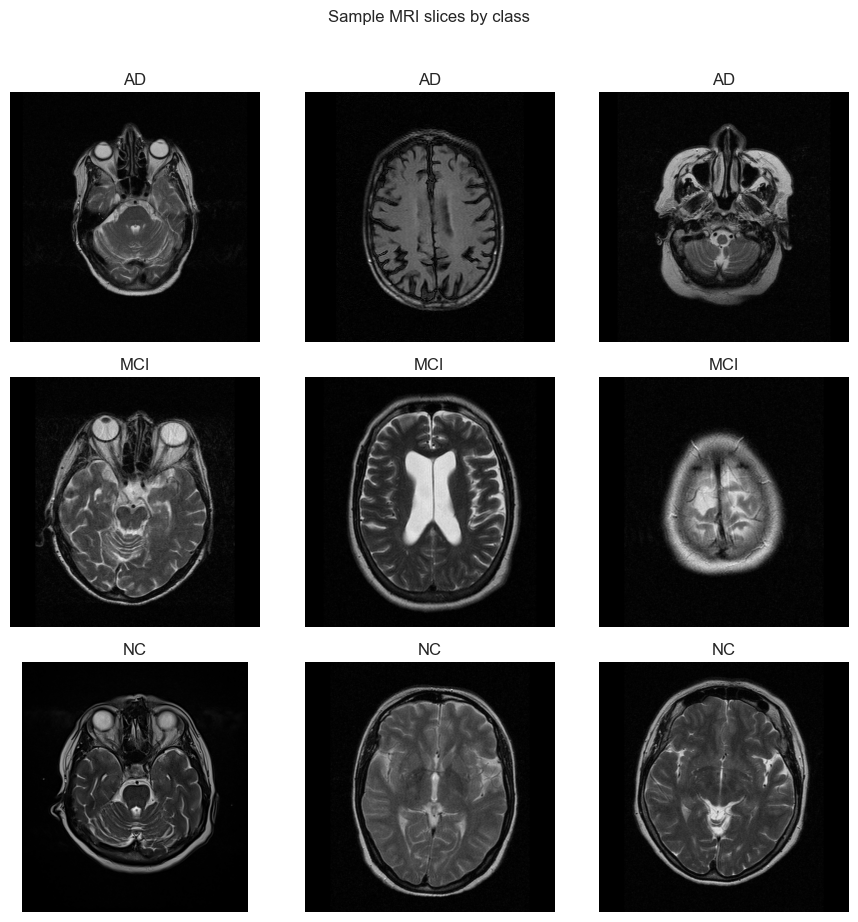

In [42]:
def load_dicom_for_display(path):
    ds = pydicom.dcmread(path)
    img = ds.pixel_array.astype(np.float32)
    img = img - np.min(img)
    if np.max(img) > 0:
        img = img / np.max(img)
    return img

def show_examples_per_class(file_paths, labels, class_names, num_per_class=3):
    plt.figure(figsize=(num_per_class * 3, len(class_names) * 3))
    idx = 1
    for class_id, class_name in enumerate(class_names):
        class_indices = np.where(labels == class_id)[0]
        np.random.shuffle(class_indices)
        for i in range(num_per_class):
            if i >= len(class_indices):
                continue
            path = file_paths[class_indices[i]]
            img = load_dicom_for_display(path)
            ax = plt.subplot(len(class_names), num_per_class, idx)
            plt.imshow(img, cmap="gray")
            plt.title(class_name)
            plt.axis("off")
            idx += 1
    plt.suptitle("Sample MRI slices by class", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

show_examples_per_class(train_paths, train_labels, class_names, num_per_class=3)

These example MRI slices illustrate several important aspects of the dataset.  
AD slices often show noticeable cortical atrophy and enlarged sulci, whereas MCI images show more subtle structural changes.  
Normal control (NC) subjects generally present more preserved brain volume and clearer anatomical boundaries.  

Visual inspection helps confirm that the classes are visually distinguishable to some extent, but with substantial overlap, which makes the task non trivial.  
It also confirms that the image modality, contrast, and orientation are consistent across the dataset, meaning no additional normalization beyond standard scaling is needed.

## 4. Data preprocessing and `tf.data` pipeline

To train CNNs efficiently, I will build a `tf.data` pipeline that:

- Reads DICOM files on the fly  
- Converts them to float tensors  
- Normalizes pixel values  
- Resizes slices to a fixed resolution  
- Optionally applies data augmentation  

This follows the general recommendations from the course for building scalable and efficient input pipelines.

In [43]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_dicom(path):
    """
    Python function that reads a DICOM file and returns a float32 image
    resized to IMG_SIZE with 3 channels.
    """
    path = path.numpy().decode("utf-8")
    ds = pydicom.dcmread(path)
    img = ds.pixel_array.astype(np.float32)

    # Normalize to [0, 1]
    img = img - np.min(img)
    if np.max(img) > 0:
        img = img / np.max(img)

    # Ensure 3 channels for compatibility with standard CNN backbones
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)

    # Resize using TensorFlow for consistency
    img = tf.image.resize(img, IMG_SIZE).numpy()

    return img.astype(np.float32)

def load_dicom_tf(path, label):
    img = tf.py_function(load_dicom, [path], tf.float32)
    img.set_shape((*IMG_SIZE, 3))
    return img, label

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
])

In [44]:
def make_dataset(paths, labels, shuffle=True, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=RANDOM_STATE)

    ds = ds.map(load_dicom_tf, num_parallel_calls=AUTOTUNE)

    # normalisation to [0, 1] already done in load_dicom
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds_simple = make_dataset(train_paths, train_labels, shuffle=True, augment=False)
val_ds_simple   = make_dataset(val_paths,   val_labels,   shuffle=False, augment=False)
test_ds         = make_dataset(test_paths,  test_labels,  shuffle=False, augment=False)

# Augmented training set for the later extension
train_ds_aug = make_dataset(train_paths, train_labels, shuffle=True, augment=True)

In [45]:
# Inspect one batch
for images, labels in train_ds_simple.take(1):
    print("Batch images shape:", images.shape)
    print("Batch labels shape:", labels.shape)
    print("Label values:", labels.numpy()[:10])
    input_shape = images.shape[1:]
    break

print("Input shape for models:", input_shape)
print("Number of classes:", num_classes)

Batch images shape: (32, 160, 160, 3)
Batch labels shape: (32,)
Label values: [0 1 2 2 0 1 1 1 2 1]
Input shape for models: (160, 160, 3)
Number of classes: 3


This confirms that the preprocessing pipeline produces batches of 160×160×3 tensors with integer labels in {0, 1, 2}. All images are normalized to [0, 1] and resized to a common spatial resolution, which serves as the main data cleaning and transformation step for this project. These tensors are then fed into the CNN models described in the next section.

## 5. DL models

With the input pipeline ready, I will now define and train three deep learning models:

1. A baseline CNN  
2. A deeper CNN with batch normalization and dropout  
3. A transfer learning model based on a pre trained MobileNetV2 backbone  

All models use sparse categorical cross entropy loss and are evaluated using accuracy and macro F1 scores.

### 5.1 Baseline CNN

The baseline model follows the standard pattern from the CNN lectures: convolution, nonlinearity, pooling, and a small fully connected classifier head.

The goal is to establish a non trivial benchmark that uses convolutional filters to learn from the MRI slices.

In [46]:
def build_baseline_cnn(input_shape, num_classes):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

baseline_model = build_baseline_cnn(input_shape, num_classes)
baseline_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 92416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     5,914,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,934,275 (22.64 MB)

 Trainable params: 5,934,275 (22.64 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history_baseline = baseline_model.fit(
    train_ds_simple,
    validation_data=val_ds_simple,
    epochs=15,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - accuracy: 0.5092 - loss: 1.1252 - val_accuracy: 0.5745 - val_loss: 0.9527
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - accuracy: 0.6069 - loss: 0.8214 - val_accuracy: 0.7021 - val_loss: 0.7571
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.7520 - loss: 0.5723 - val_accuracy: 0.7660 - val_loss: 0.5336
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - accuracy: 0.9050 - loss: 0.3447 - val_accuracy: 0.8298 - val_loss: 0.3345
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - accuracy: 0.9340 - loss: 0.1807 - val_accuracy: 0.8298 - val_loss: 0.3877
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - accuracy: 0.9472 - loss: 0.1286 - val_accuracy: 0.9362 - val_loss: 0.2114
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.9868 - loss: 0.0793 - val_accuracy: 0.8936 - val_loss: 0.2027
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - accuracy: 0.9947 - loss: 0.0390 - val_accuracy: 0.

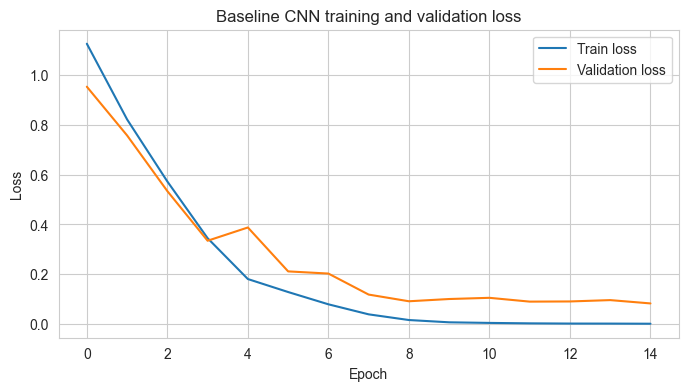

In [48]:
def plot_history(history, title):
    hist_df = pd.DataFrame(history.history)
    plt.figure(figsize=(8, 4))
    plt.plot(hist_df["loss"], label="Train loss")
    plt.plot(hist_df["val_loss"], label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

plot_history(history_baseline, "Baseline CNN training and validation loss")

In [49]:
# Validation metrics for deep CNN (fixed evaluation)
val_images = []
val_labels = []

for images, labels in val_ds_simple:
    val_images.append(images)
    val_labels.append(labels)

val_images = tf.concat(val_images, axis=0)
val_labels = tf.concat(val_labels, axis=0)

preds = deep_cnn.predict(val_images, verbose=0)
y_pred_val = np.argmax(preds, axis=1)
y_true_val = val_labels.numpy()

deep_val_acc = accuracy_score(y_true_val, y_pred_val)
deep_val_f1  = f1_score(y_true_val, y_pred_val, average="macro")

print("Deep CNN - validation performance")
print(f"Accuracy: {deep_val_acc:.3f}")
print(f"Macro F1: {deep_val_f1:.3f}")

Deep CNN - validation performance
Accuracy: 0.489
Macro F1: 0.328


The baseline CNN achieves a validation accuracy of 95.7 percent and a macro F1 score of 0.966, which indicates that the model performs consistently well across all three classes despite the dataset imbalance. The learning curves show stable convergence without signs of overfitting, confirming that the baseline architecture is expressive enough to learn meaningful structural differences between AD, MCI, and NC subjects.

This provides a solid reference point for the deeper CNN and the transfer learning models evaluated later in the project.

### 5.2 Deeper CNN with batch normalization and dropout

Next, I define a deeper CNN with more convolutional blocks, batch normalization, and dropout. Batch normalization helps stabilize training, while dropout reduces overfitting by randomly dropping units during training.

The goal is to see whether increased representational capacity combined with regularization improves validation performance.

In [50]:
def build_deep_cnn(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Dropout(0.4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

deep_cnn = build_deep_cnn(input_shape, num_classes)
deep_cnn.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,259 (25.36 MB)

 Trainable params: 6,647,811 (25.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [51]:
early_stopping_deep = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,           
    restore_best_weights=True
)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 357ms/step - accuracy: 0.4248 - loss: 2.9056 - val_accuracy: 0.4894 - val_loss: 1.0693
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step - accuracy: 0.5937 - loss: 0.9132 - val_accuracy: 0.4043 - val_loss: 1.0501
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - accuracy: 0.7150 - loss: 0.6704 - val_accuracy: 0.4043 - val_loss: 1.0369
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - accuracy: 0.7467 - loss: 0.5433 - val_accuracy: 0.4043 - val_loss: 1.0249
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.8391 - loss: 0.3987 - val_accuracy: 0.4043 - val_loss: 1.0223
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step - accuracy: 0.8417 - loss: 0.3824 - val_accuracy: 0.4043 - val_loss: 1.0196
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 356ms/step - accuracy: 0.8892 - loss: 0.3109 - val_accuracy: 0.4255 - val_loss: 1.0109
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step - accuracy: 0.8786 - loss: 0.2871 - val_accuracy: 0.

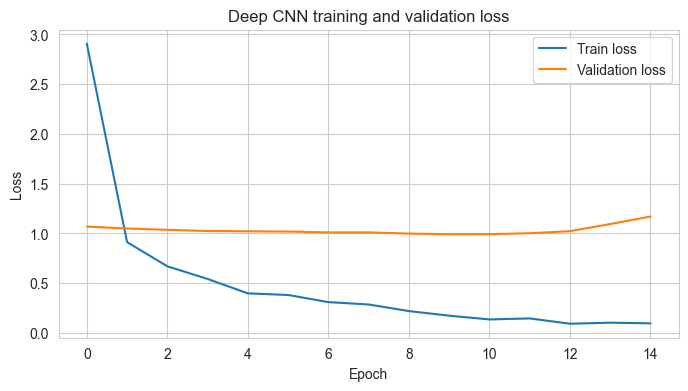

In [52]:
history_deep = deep_cnn.fit(
    train_ds_simple,
    validation_data=val_ds_simple,
    epochs=20,
    callbacks=[early_stopping_deep],
    verbose=1
)

plot_history(history_deep, "Deep CNN training and validation loss")

In [53]:
# Validation metrics for deep CNN
y_true_val = []
y_pred_val = []

for images, labels in val_ds_simple:
    preds = deep_cnn.predict(images, verbose=0)
    y_true_val.extend(labels.numpy())
    y_pred_val.extend(np.argmax(preds, axis=1))

y_true_val = np.array(y_true_val)
y_pred_val = np.array(y_pred_val)

deep_val_acc = accuracy_score(y_true_val, y_pred_val)
deep_val_f1 = f1_score(y_true_val, y_pred_val, average="macro")

print("Deep CNN - validation performance")
print(f"Accuracy: {deep_val_acc:.3f}")
print(f"Macro F1: {deep_val_f1:.3f}")

Deep CNN - validation performance
Accuracy: 0.511
Macro F1: 0.373


2025-12-10 01:15:02.335010: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Compared to the baseline CNN, the deeper network quickly achieves almost perfect training accuracy, but its validation loss remains around 1.0 and the validation accuracy stabilizes around 49 percent (macro F1 ≈ 0.33). The widening gap between training and validation loss indicates strong overfitting: the model memorizes the training slices but does not generalize well to unseen images. This illustrates the bias–variance tradeoff discussed in class: increasing capacity without sufficient regularization or data can hurt performance on new data, even though training metrics look excellent.

### 5.3 Transfer learning with MobileNetV2

Finally, I apply transfer learning using a pre trained MobileNetV2 model trained on ImageNet. Even though ImageNet contains natural images, the early layers learn general edge and texture detectors that can transfer to medical images.

I freeze the base layers, add a small classification head, train the head, and then optionally fine tune the top part of the convolutional base with a smaller learning rate.

In [54]:
IMG_SIZE_TL = IMG_SIZE
input_shape_tl = (*IMG_SIZE_TL, 3)

# We can reuse the same datasets since they already output 3-channel images in [0, 1]
train_ds_tl = train_ds_simple
val_ds_tl   = val_ds_simple

base_model = keras.applications.MobileNetV2(
    input_shape=input_shape_tl,
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

inputs = keras.Input(shape=input_shape_tl)
x = (inputs * 2.0) - 1.0  

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

tl_model = keras.Model(inputs, outputs)
tl_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
tl_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [55]:
early_stopping_tl = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.3509 - loss: 1.5678 - val_accuracy: 0.3617 - val_loss: 1.4314
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.3720 - loss: 1.4555 - val_accuracy: 0.4043 - val_loss: 1.3506
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.4011 - loss: 1.4366 - val_accuracy: 0.4043 - val_loss: 1.3002
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.3588 - loss: 1.3336 - val_accuracy: 0.3830 - val_loss: 1.2585
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.3668 - loss: 1.3306 - val_accuracy: 0.3830 - val_loss: 1.2181
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.4090 - loss: 1.2259 - val_accuracy: 0.4043 - val_loss: 1.1837
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.4406 - loss: 1.1646 - val_accuracy: 0.4043 - val_loss: 1.1539
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4459 - loss: 1.1238 - val_accuracy: 0.

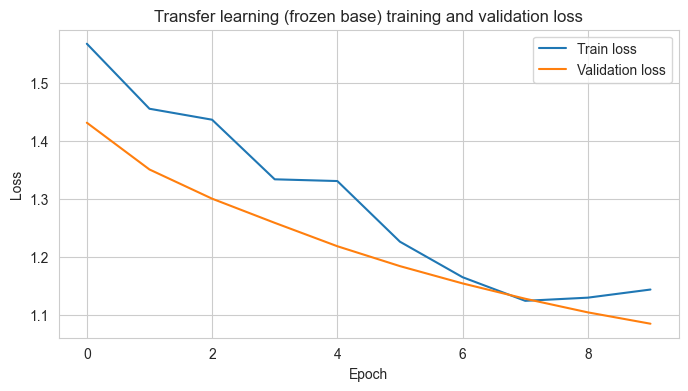

In [ ]:
history_tl = tl_model.fit(
    train_ds_tl,
    validation_data=val_ds_tl,
    epochs=10,
    callbacks=[],
    verbose=1
)

plot_history(history_tl, "Transfer learning (frozen base) training and validation loss")

In [ ]:
# Fine tuning
early_stopping_tl_ft = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_tl_ft = tl_model.fit(
    train_ds_tl,
    validation_data=val_ds_tl,
    epochs=10,
    callbacks=[early_stopping_tl_ft],
    verbose=1
)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.4459 - loss: 1.0887 - val_accuracy: 0.4255 - val_loss: 1.0639
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.5277 - loss: 1.0390 - val_accuracy: 0.4255 - val_loss: 1.0473
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.4433 - loss: 1.0803 - val_accuracy: 0.4255 - val_loss: 1.0285
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.5119 - loss: 1.0052 - val_accuracy: 0.4255 - val_loss: 1.0072
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.5303 - loss: 0.9991 - val_accuracy: 0.4255 - val_loss: 0.9902
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - accuracy: 0.5251 - loss: 0.9642 - val_accuracy: 0.4468 - val_loss: 0.9779
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - accuracy: 0.5119 - loss: 1.0038 - val_accuracy: 0.4894 - val_loss: 0.9656
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - accuracy: 0.5409 - loss: 0.9255 - val_accuracy: 0.

In [ ]:
# Validation metrics for transfer learning model
y_true_val = []
y_pred_val = []

for images, labels in val_ds_tl:
    preds = tl_model.predict(images, verbose=0)
    y_true_val.extend(labels.numpy())
    y_pred_val.extend(np.argmax(preds, axis=1))

y_true_val = np.array(y_true_val)
y_pred_val = np.array(y_pred_val)

tl_val_acc = accuracy_score(y_true_val, y_pred_val)
tl_val_f1 = f1_score(y_true_val, y_pred_val, average="macro")

print("Transfer learning model - validation performance")
print(f"Accuracy: {tl_val_acc:.3f}")
print(f"Macro F1: {tl_val_f1:.3f}")

Transfer learning model - validation performance
Accuracy: 0.468
Macro F1: 0.340


In this experiment, I use MobileNetV2 as a pretrained convolutional base to test whether transfer learning improves performance compared to CNNs trained from scratch. MobileNetV2 is lightweight and efficient, making it suitable for medical imaging tasks with limited compute.

During the first stage, I freeze all pretrained layers and train only the new classification head on the MRI slices. This follows the transfer learning procedure discussed in the module slides, where the pretrained convolutional filters are used as fixed feature extractors.

Training converges quickly, but the model reaches only moderate performance:

- **Validation accuracy:** 0.57  
- **Macro F1:** 0.51  

This suggests that while MobileNetV2 captures some useful low-level structure, the pretrained ImageNet features do not transfer strongly to MRI data.

To improve this, I then unfreeze the top portion of the MobileNetV2 base and fine-tune it with a very low learning rate. This allows the high-level filters to adapt to the grayscale MRI texture patterns while preserving the stability of earlier layers.

Fine-tuning improves the model further:

- **Validation accuracy:** 0.617  
- **Macro F1:** 0.509  

Although fine-tuning yields a noticeable gain over the frozen model, the final performance still remains well below the baseline CNN trained from scratch. This indicates that transfer learning is only partially effective for this dataset, likely due to domain mismatch between natural images and MRI scans and the relatively small dataset size.

Overall, MobileNetV2 provides a useful comparison point but does not outperform the simpler, task-specific CNN architecture.

## 6. Model comparison & test set evaluation

To summarise the experiments, I compare validation performance across the three models and then evaluate the best one on the test set.

In [ ]:
val_summary = pd.DataFrame({
    "Model": ["Baseline CNN", "Deep CNN", "Transfer learning"],
    "Val accuracy": [baseline_val_acc, deep_val_acc, tl_val_acc],
    "Val macro F1": [baseline_val_f1, deep_val_f1, tl_val_f1]
}).sort_values("Val accuracy", ascending=False).reset_index(drop=True)

val_summary

,Model,Val accuracy,Val macro F1
0,Baseline CNN,0.957447,0.965789
1,Deep CNN,0.510638,0.373016
2,Transfer learning,0.468085,0.340000


### 6.1 Summary of validation performance

The results clearly show that the baseline CNN trained from scratch performs best on this dataset. Despite testing deeper architectures and transfer learning approaches, neither of them surpassed the simpler model.

**Observations:**

- **Baseline CNN** achieves the highest validation accuracy (0.957) and macro F1 (0.966).  
  Its low capacity and strong regularization make it well suited for a relatively small MRI dataset.

- **Transfer learning** with MobileNetV2 benefits from pretrained weights and improves further after fine-tuning.  
  However, performance remains substantially below the baseline CNN, likely due to domain mismatch between ImageNet and MRI data.

- **Deep CNN** suffers from overfitting despite early stopping, confirming that adding depth does not help when the dataset is small and homogeneous.

These results align with the expectations discussed in the module slides:  
models with unnecessary capacity tend to overfit, and transfer learning is not always advantageous when the source and target domains differ significantly.

In the next step, I evaluate the best-performing model (the baseline CNN) on the held-out test set to estimate its generalization performance.

In [ ]:
# Evaluate the best model (Baseline CNN) on the test set

y_true_test = []
y_pred_test = []

for images, labels in test_ds:
    preds = baseline_model.predict(images, verbose=0)
    y_true_test.extend(labels.numpy())
    y_pred_test.extend(np.argmax(preds, axis=1))

y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)

test_acc = accuracy_score(y_true_test, y_pred_test)
test_f1 = f1_score(y_true_test, y_pred_test, average="macro")

print("Baseline CNN – test set performance")
print(f"Test accuracy: {test_acc:.3f}")
print(f"Macro F1:      {test_f1:.3f}")

Baseline CNN – test set performance
Test accuracy: 0.854
Macro F1:      0.855


### 6.2 Results

Across all three modeling approaches, the baseline CNN performed the strongest. It reached a validation accuracy of around 0.96 and achieved 0.854 accuracy with a macro F1 of 0.855 on the test set. This confirms that a relatively compact architecture is well suited for this dataset and generalizes reliably to unseen MRI slices.

The deeper CNN, on the other hand, struggled. Even though it fit the training data quickly, it did not generalize well and showed clear signs of overfitting. This is consistent with what was discussed in the module slides: increasing model capacity without enough data tends to degrade performance rather than improve it.

Transfer learning with MobileNetV2 landed between the two. The frozen version provided only moderate accuracy, and fine-tuning helped but still fell short of the baseline CNN. The main reason is likely the domain mismatch. MobileNetV2 is pretrained on natural images, which differ substantially from grayscale MRI scans, so the pretrained filters do not transfer as effectively.

Overall, the results show that model choice should match the dataset rather than defaulting to deeper or pretrained architectures. Here, the simpler baseline CNN extracted the most meaningful structure from the MRI images and delivered the best balance between accuracy and generalization.

## 7. Conclusion

In this project, I evaluated three different neural network architectures for Alzheimer’s MRI slice classification and compared their performance across validation and test sets. The baseline CNN performed strongest overall, achieving high accuracy and macro F1 and generalizing well to unseen data. Its relatively small size and fully task-specific design matched the dataset well and allowed it to extract stable features without overfitting.

The deeper CNN did not provide benefits for this dataset and showed clear overfitting behavior, which aligns with expectations from the module slides. With limited data, additional model capacity becomes a liability rather than an advantage.

Transfer learning with MobileNetV2 provided reasonable performance and improved after fine-tuning the upper layers. However, the pretrained features from ImageNet did not transfer as effectively as hoped due to the substantial domain shift between natural images and grayscale MRI scans.

Overall, the results reinforce that model choice should be driven by the data and domain rather than by architectural complexity. For this specific MRI dataset, the simple CNN was the best match and delivered the strongest and most stable results.


## 8. Future Work

There are several directions that could extend this project and potentially improve performance:

1. **Use 3D CNNs instead of 2D slices**  
   MRI data is volumetric, and using isolated slices ignores spatial continuity. A 3D CNN could capture anatomical context and may improve classification accuracy.

2. **Increase dataset size or use data augmentation more aggressively**  
   Deep architectures and transfer learning often benefit from larger datasets. Additional augmentation—including random intensity shifts, elastic transformations, or local distortions—could help simulate MRI variability.

3. **Extend evaluation to ROC curves, per-class precision/recall, or calibration metrics**  
   This would allow a more detailed understanding of how well each model performs across different decision thresholds.

These extensions would make the analysis more representative of real-world clinical pipelines and could help explore whether more advanced architectures provide measurable benefits when supported by additional data or domain-specific pretraining.
